##### <b>Kelas : Kaizen
##### Nama Anggota Kelompok</b>
* Muhammad Ahyaruddin
* Jatmiar Fikriaziz
* Muhammad Baha'udin
* Nindy Elisa Nababan
* Tania Argadini
* Noviyanti
* Chika Marsha Fazrina







# Studi kasus environment OpenAI yang bisa diselesaikan dengan Monte Carlo
---
## CartPole-v1
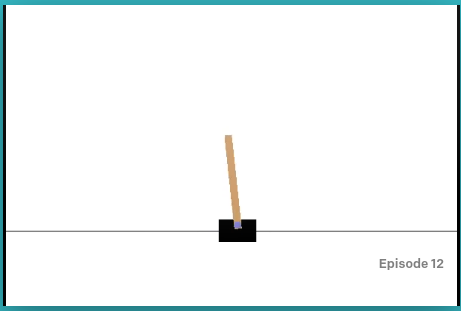

## 1. Mekanisme kerja dari program

Sebuah tiang dipasang pada sambungan yang tidak digerakkan oleh kereta, yang bergerak sepanjang lintasan tanpa gesekan. Sistem dikendalikan dengan menerapkan gaya +1 atau -1 pada kereta. Pendulum dimulai dengan keadaan tegak, dan tujuannya adalah mencegahnya jatuh. Reward +1 diberikan untuk setiap langkah waktu yang mempertahankan tiang tetap tegak. Episode berakhir ketika tiang lebih dari 15 derajat dari vertikal, atau kereta bergerak lebih dari 2,4 unit dari titik pusat.

## 2. Algoritma Monte Carlo dalam bentuk pseudocode untuk penyelesaian masalah tersebut

`1. import <- packages`<br>
`2. instantiate <- environment & agent`<br>
`3. define <- policy`<br>
`4. reinforce`<br>
`5. learning progress -> plot`<br>
`6. animate`


## 3. Program untuk algoritma nomor 2

### Import Packages

In [ ]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16,10)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(9)

import base64, io

# Untuk visualisasi
from gym.wrappers.monitoring import video_recorder
from IPython import display
from IPython.display import HTML
import glob

In [ ]:
# Menggunakan CUDA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Instansiasi Environment dan Agent

In [ ]:
env = gym.make('CartPole-v1')
env.seed(0)

print("Observation Space :",env.observation_space)
print("Action Space :",env.action_space)

Observation Space : Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Action Space : Discrete(2)


### Mendefinisikan Policy

In [ ]:
class Policy(nn.Module):
  def __init__(self, state_size=4, action_size=2, hidden_size=32):
    super(Policy, self).__init__()
    self.fc1 = nn.Linear(state_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, action_size)

  def forward(self, state):
    x = F.relu(self.fc1(state))
    x = self.fc2(x)

    # Hanya memperhitungkan kemungkinan action 1 dimensi
    return F.softmax(x, dim=1)

  def act(self, state):
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    probs = self.forward(state).cpu()
    model = Categorical(probs)
    action = model.sample()
    return action.item(), model.log_prob(action)

### Reinforce

In [ ]:
def reinforce(policy, optimizer, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
  scores_deque = deque(maxlen=100)
  scores = []
  for e in range(1, n_episodes):
    saved_log_probs = []
    rewards = []
    state = env.reset()

    # Mengumpulkan lintasan
    for t in range(max_t):
      # Sampel action dari policy saat ini
      action, log_prob = policy.act(state)
      saved_log_probs.append(log_prob)
      state, reward, done,_ = env.step(action)
      rewards.append(reward)
      if done:
        break
    
    # Menghitung total expected reward
    scores_deque.append(sum(rewards))
    scores.append(sum(rewards))

    # Hitung kembali total reward dengan menerapkann faktor diskon
    discounts = [gamma ** i for i in range(len(rewards) + 1)]
    R = sum([a * b for a,b in zip(discounts, rewards)])

    # Menghitung policy loss
    policy_loss = []
    for log_prob in saved_log_probs:
      # Karena menggunakan Gradient Ascent, bukan Descent, maka harus mengkalkulasi dengan reward negatif.
      policy_loss.append(-log_prob * R)
    
    # Selanjutnya gabungkan seluruh policy loss pada dimensi ke-0
    policy_loss = torch.cat(policy_loss).sum()

    # Backpropagation
    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()

    if e % print_every == 0:
      print("Episode {}\tAverage Score: {:.2f}".format(e, np.mean(scores_deque)))
    if np.mean(scores_deque) >= 195.0:
      print("Environment solved in {:d} episodes!\tAverage Score: {:.2f}".format(e-100, np.mean(scores_deque)))
      break
  
  return scores

### Run

In [ ]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
scores = reinforce(policy, optimizer, n_episodes=2000)

Episode 100	Average Score: 22.85
Episode 200	Average Score: 47.50
Episode 300	Average Score: 62.33
Episode 400	Average Score: 26.46
Episode 500	Average Score: 65.54
Episode 600	Average Score: 76.67
Episode 700	Average Score: 148.02
Episode 800	Average Score: 62.14
Episode 900	Average Score: 146.13
Environment solved in 863 episodes!	Average Score: 195.71


### Plot Learning Progress

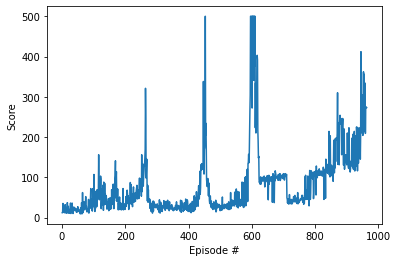

In [ ]:
# Plot scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## 4. Perbedaan antara DP dan MC dalam menyelesaikan Frozen Lake Problem
    - DP harus memiliki model dari lingkungan sedangkan MC tidak harus tahu tentang lingkungan (pemodelan lingkungan).
    - DP melakukan update nilai per step dan MC melakukan update value setelah selesai satu episode.
    - DP bersifat bootstrapping sedangkan MC melakukan rata-rata terhadap return untuk memperbaharui value.